In [2]:
import findspark

In [4]:
findspark.init()

In [7]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext as sqlContext
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator

In [8]:
spark = SparkSession.builder.appName('ttss4').getOrCreate()
data=spark.read.csv('/Users/tuanphattrantruong/Documents/blurred-hcmut-data/mssv_dtk_dc_drop_row_all_na.csv', header=True, inferSchema=True)

In [12]:
df=pd.read_csv('/Users/tuanphattrantruong/Documents/blurred-hcmut-data/mssv_dtk_dc_drop_row_all_na.csv')
df.columns

Index(['MASV1', 'LA1003', 'MI1003', 'PE1003', 'CH1003', 'MT1003', 'PH1003',
       'LA1005', 'PE1005', 'MT1005', 'MT1007', 'LA1007', 'MT1009', 'LA1009',
       'MT2001', 'PE1007', 'SP1007', 'SP1003', 'SP1005', 'SP1009'],
      dtype='object')

In [14]:
df.head()

,MASV1,LA1003,MI1003,PE1003,CH1003,MT1003,PH1003,LA1005,PE1005,MT1005,MT1007,LA1007,MT1009,LA1009,MT2001,PE1007,SP1007,SP1003,SP1005,SP1009
0,10438.0,10.0,DT,7.0,7.5,9.0,7.0,10.0,5.0,8.5,6.5,9.5,9.0,7.0,7.0,5.0,NaN,9.0,7.5,7.5
1,15731.0,10.0,DT,7.0,8.0,7.0,5.5,10.0,5.0,7.0,7.0,10.0,7.5,8.0,6.0,8.0,NaN,8.0,NaN,NaN
2,16564.0,10.0,DT,6.0,6.0,6.5,6.0,10.0,5.0,13.0,7.5,10.0,5.0,10.0,4.0,6.0,0.0,7.0,5.5,7.5
3,19461.0,NaN,NaN,6.0,8.5,NaN,NaN,NaN,6.0,7.0,NaN,NaN,NaN,NaN,6.0,3.0,6.5,5.0,7.0,NaN
4,23086.0,6.5,NaN,6.0,NaN,6.5,6.0,6.0,7.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df2=df[['MASV1','MT1003','MT1005','MT1007']]

In [17]:
df2.shape

(18194, 4)

In [19]:
df2=df2.dropna(axis=0,how='any')

In [25]:
df2.shape

(11957, 4)

In [24]:
def convert(x):
    try:
        t = float(x)
        return t
    except:
        return 13.0

In [27]:
for x in df2.columns:
    if isinstance(x,object):
        df2[x]= df2[x].map(convert)

In [29]:
df2 = df2[(df2.MT1003<10.1) & (df2.MT1005<10.1) & (df2.MT1007<10.1)]

In [32]:
df2.shape

(10703, 4)

In [35]:
mySchema = StructType([StructField("MASV1", FloatType(), True),StructField("MT1003", FloatType(), True),StructField("MT1005", FloatType(), True),StructField("MT1007", FloatType(), True)])
sdf = spark.createDataFrame(df2,schema=mySchema)
type(sdf)

pyspark.sql.dataframe.DataFrame

In [37]:
vecAssembler = VectorAssembler(inputCols=['MT1003', 'MT1005','MT1007'], outputCol="features")
df_kmeans = vecAssembler.transform(sdf).select('MASV1', 'features')
df_kmeans.show()

+--------+-------------+
|   MASV1|     features|
+--------+-------------+
| 10438.0|[9.0,8.5,6.5]|
| 15731.0|[7.0,7.0,7.0]|
| 23086.0|[6.5,2.0,8.0]|
| 26172.0|[6.0,6.0,8.0]|
| 26306.0|[9.0,9.5,9.0]|
| 33974.0|[5.5,5.5,9.5]|
| 61504.0|[8.5,6.5,3.5]|
| 66797.0|[5.0,6.5,7.5]|
| 75321.0|[5.0,5.0,6.0]|
| 77173.0|[6.5,8.0,7.0]|
| 81657.0|[6.5,6.0,6.0]|
| 94690.0|[9.0,6.0,7.0]|
|116572.0|[5.5,5.0,6.5]|
|118048.0|[6.0,2.0,7.0]|
|137129.0|[1.0,0.0,6.0]|
|143503.0|[6.0,2.0,7.0]|
|158147.0|[0.0,5.5,5.0]|
|161614.0|[8.0,9.0,8.5]|
|182309.0|[2.5,6.0,5.5]|
|195989.0|[7.0,7.5,8.0]|
+--------+-------------+
only showing top 20 rows



In [39]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)

Text(0,0.5,'cost')

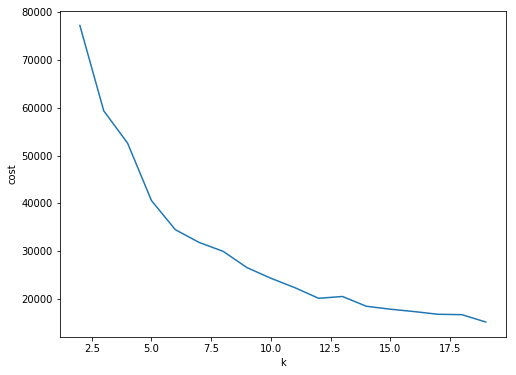

In [41]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [101]:
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[7.49422668 7.55615314 8.32257672]
[5.40622407 1.62946058 6.1626556 ]
[1.82811016 1.50237417 3.65432099]
[1.78024417 5.21975583 6.127303  ]
[5.75697155 5.68394075 6.57044439]


In [102]:
predictions= model.transform(df_kmeans)
transformed = predictions.select('MASV1', 'prediction')
rows = transformed.collect()
print(rows)

[Row(MASV1=10438.0, prediction=0), Row(MASV1=15731.0, prediction=0), Row(MASV1=23086.0, prediction=1), Row(MASV1=26172.0, prediction=4), Row(MASV1=26306.0, prediction=0), Row(MASV1=33974.0, prediction=4), Row(MASV1=61504.0, prediction=4), Row(MASV1=66797.0, prediction=4), Row(MASV1=75321.0, prediction=4), Row(MASV1=77173.0, prediction=0), Row(MASV1=81657.0, prediction=4), Row(MASV1=94690.0, prediction=0), Row(MASV1=116572.0, prediction=4), Row(MASV1=118048.0, prediction=1), Row(MASV1=137129.0, prediction=2), Row(MASV1=143503.0, prediction=1), Row(MASV1=158147.0, prediction=3), Row(MASV1=161614.0, prediction=0), Row(MASV1=182309.0, prediction=3), Row(MASV1=195989.0, prediction=0), Row(MASV1=204873.0, prediction=3), Row(MASV1=209312.0, prediction=0), Row(MASV1=216361.0, prediction=4), Row(MASV1=223768.0, prediction=1), Row(MASV1=226368.0, prediction=0), Row(MASV1=251450.0, prediction=0), Row(MASV1=252859.0, prediction=4), Row(MASV1=253551.0, prediction=4), Row(MASV1=268646.0, prediction=

In [103]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(model.transform(df_kmeans))
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5201758118320078


In [76]:
mySchema1 = StructType([StructField("MASV1", FloatType(), True),StructField("prediction", IntegerType(), True)])
rows1 = spark.createDataFrame(rows,schema=mySchema1)
rows1.show()

+--------+----------+
|   MASV1|prediction|
+--------+----------+
| 10438.0|         0|
| 15731.0|         0|
| 23086.0|         1|
| 26172.0|         4|
| 26306.0|         0|
| 33974.0|         4|
| 61504.0|         4|
| 66797.0|         4|
| 75321.0|         4|
| 77173.0|         0|
| 81657.0|         4|
| 94690.0|         0|
|116572.0|         4|
|118048.0|         1|
|137129.0|         2|
|143503.0|         1|
|158147.0|         3|
|161614.0|         0|
|182309.0|         3|
|195989.0|         0|
+--------+----------+
only showing top 20 rows



In [78]:
df_pred = rows1.join(sdf, 'MASV1')
df_pred.show()

+-----------+----------+------+------+------+
|      MASV1|prediction|MT1003|MT1005|MT1007|
+-----------+----------+------+------+------+
|   494028.0|         0|   7.5|   9.0|   9.5|
|  2896868.0|         1|   4.0|   2.5|   7.0|
|  4742989.0|         1|   5.0|   0.0|   6.5|
|  8263150.0|         4|   5.0|   4.0|   6.0|
|  8773252.0|         2|   1.0|   0.0|   5.0|
|  8909392.0|         0|   8.0|   7.0|   6.5|
|1.0072233E7|         4|   5.0|   9.0|   5.5|
|1.0671582E7|         0|   9.5|   9.0|  10.0|
|1.1768077E7|         4|   6.5|   5.0|   5.0|
|1.4150215E7|         4|   6.0|   5.5|   6.5|
| 1.521343E7|         0|   7.0|   8.5|   9.0|
|1.5320448E7|         4|   6.0|   4.0|   7.5|
|1.7479346E7|         0|   7.5|   8.0|   9.0|
| 1.826279E7|         4|   6.5|   7.0|   7.0|
|1.9762058E7|         4|   5.0|   6.5|   8.0|
| 2.132897E7|         1|   4.0|   1.5|   6.0|
|2.1435982E7|         4|   4.5|   6.0|   6.0|
|2.2186548E7|         0|   7.0|   8.5|   7.5|
|2.2272508E7|         0|   7.0|   

In [80]:
pddf_pred = df_pred.toPandas().set_index('MASV1')
pddf_pred.shape

(10705, 4)

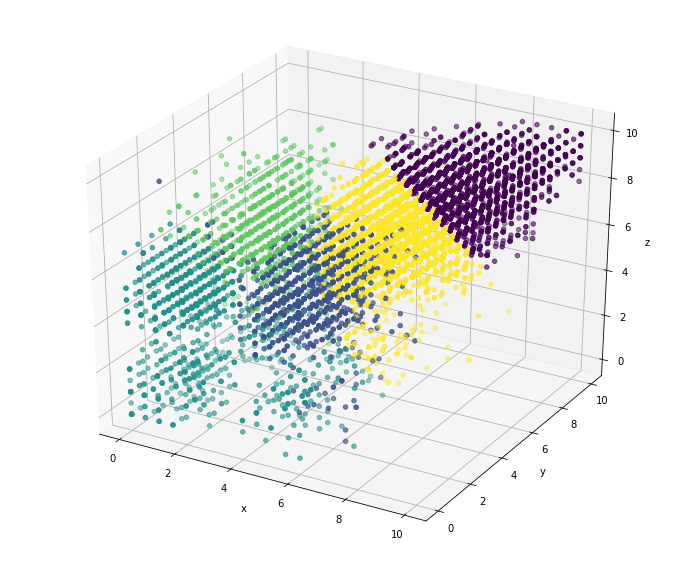

In [83]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.MT1003, pddf_pred.MT1005, pddf_pred.MT1007, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [86]:
adf=pd.read_csv('/Users/tuanphattrantruong/Documents/blurred-hcmut-data/student_info.csv')
adf.shape

(61627, 6)

In [88]:
result = pddf_pred.join(adf.set_index('MASV1'))
result.sort_values(by='prediction', ascending=False)

,prediction,MT1003,MT1005,MT1007,F_MAKH,F_TENLOP,F_KHOI,F_MANG,F_TENNGVN
MASV1,,,,,,,,,
88320080.0,4,6.0,6.0,8.0,GT,GT1704,DHGTGTH17,GTH,Kỹ thuật Giao thông
45771544.0,4,5.5,5.0,6.5,NaN,NaN,NaN,NaN,NaN
87068096.0,4,6.0,6.5,7.0,NaN,NaN,NaN,NaN,NaN
43935316.0,4,5.5,6.8,8.2,XD,XD17B2D1,DHXDXC217,XC2,XD Dân dụng & CN(B2)
87091176.0,4,5.5,5.5,1.0,NaN,NaN,NaN,NaN,NaN
43889872.0,4,7.0,5.0,5.5,NaN,NaN,NaN,NaN,NaN
43874100.0,4,7.0,5.0,7.5,MT,MT1502,DHMTCTT15,CTT,MT&CôngNghệ ThôngTin
43865972.0,4,6.0,6.5,5.0,NaN,NaN,NaN,NaN,NaN
43839500.0,4,6.0,6.0,6.0,MT,MT1606,DHMTCTT16,CTT,MT&CôngNghệ ThôngTin


In [90]:
result.loc[result['prediction'] == 4]['F_MAKH'].value_counts()

CK    305
XD    301
DD    251
HC    206
MT    153
VL     83
UD     82
MO     76
GT     76
DC     52
QL      1
Name: F_MAKH, dtype: int64

In [92]:
result.loc[result['prediction'] == 3]['F_MAKH'].value_counts()

XD    82
CK    75
VL    34
HC    29
UD    27
DD    26
MO    21
GT    19
MT    17
DC    11
Name: F_MAKH, dtype: int64

In [94]:
result.loc[result['prediction'] == 2]['F_MAKH'].value_counts()

XD    112
CK     60
VL     49
DD     36
MT     28
HC     24
DC     22
GT     17
UD     14
MO     13
Name: F_MAKH, dtype: int64

In [96]:
result.loc[result['prediction'] == 1]['F_MAKH'].value_counts()

XD    114
CK     91
DD     78
MT     44
HC     35
VL     27
GT     21
UD     14
MO     12
DC      9
Name: F_MAKH, dtype: int64

In [97]:
result.loc[result['prediction'] == 0]['F_MAKH'].value_counts()

DD    339
HC    254
CK    229
MT    151
XD    135
GT     40
DC     34
VL     28
UD     26
MO     13
Name: F_MAKH, dtype: int64